In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import xgboost as xgb
from tqdm.notebook import tqdm

# from xgboost import plot_importance, plot_tree

# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import auc, precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import random

plt.style.use('fivethirtyeight')

In [2]:
!nvidia-smi

Mon Apr 29 02:06:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti      On | 00000000:65:00.0 Off |                  N/A |
|  0%   37C    P8               11W / 285W|     68MiB / 12282MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Functions

In [3]:
def ts_array_create(dirname, dir_list, time_seq):
    
    columns = ['RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
               'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2']
    
    def reamin_HO_time(y_train):
        def f(L):    
            for i, e in enumerate(L):
                if e: return i+1
            return 0

        out = []
        for a2 in y_train:
            a1_out = []
            for a1 in a2:
                a1_out.append(a1.any())
      
            out.append(f(a1_out))
        return out
    
    def HO(y_train):
        out = []
        for a2 in y_train:
            if sum(a2.reshape(-1)) == 0: ho = 0
            elif sum(a2.reshape(-1)) > 0: ho = 1
            out.append(ho)
        return out

    split_time = []
    for i, f in enumerate(tqdm(dir_list)):
    
        f = os.path.join(dirname, f)
        df = pd.read_csv(f)

        # preprocess data with ffill method
        del df['Timestamp'], df['lat'], df['long'], df['gpsspeed']
        # df[columns] = df[columns].replace(0, np.nan)
        # df[columns] = df[columns].fillna(method='ffill')
        # df.dropna(inplace=True)
        
        df.replace(np.nan,0,inplace=True); df.replace('-',0,inplace=True)
        
        X = df[features]
        Y = df[target]

        Xt_list = []
        Yt_list = []

        for j in range(time_seq):
            X_t = X.shift(periods=-j)
            Xt_list.append(X_t)
    
        for j in range(time_seq,time_seq+predict_t):
            Y_t = Y.shift(periods=-(j))
            Yt_list.append(Y_t)

        # YY = Y.shift(periods=-(0))

        X_ts = np.array(Xt_list); X_ts = np.transpose(X_ts, (1,0,2)); X_ts = X_ts[:-(time_seq+predict_t-1),:,:]
        Y_ts = np.array(Yt_list); Y_ts = np.transpose(Y_ts, (1,0,2)); Y_ts = Y_ts[:-(time_seq+predict_t-1),:,:]
        split_time.append(len(X_ts))

        if i == 0:
            X_final = X_ts
            Y_final = Y_ts
        else:
            X_final = np.concatenate((X_final,X_ts), axis=0)
            Y_final = np.concatenate((Y_final,Y_ts), axis=0)

    split_time = [(sum(split_time[:i]), sum(split_time[:i])+x) for i, x in enumerate(split_time)]
    
    return X_final, np.array(HO(Y_final)), np.array(reamin_HO_time(Y_final)), split_time # forecast HO


In [4]:
def days_in_file(file, dates):
    
    for date in dates:
        if date in file: return True 
    return False

def train_valid_split(L, valid_size=0.2):
    
    length = len(L)
    v_num = int(length*valid_size)
    v_files = random.sample(L, v_num)
    t_files = list(set(L) - set(v_files))
    
    return t_files, v_files

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    print(f"Random seed set as {seed}")

# Load Data

In [5]:
# Time sequence length and prediction time length
seed = 55688
time_seq = 20
predict_t = 10
valid_ratio = 0.2

In [6]:
# Setup seed
set_seed(seed)

# Get GPU
device_count = torch.cuda.device_count()
num_of_gpus = device_count

for i in range(device_count):
    print("GPU {}: {}".format(i, torch.cuda.get_device_name(i)))
    gpu_id = i

# Save best model to 
save_path = "../model"

# Define DataSet
dirname = "../data/single"
# dirname = "/home/wmnlab/Documents/sheng-ru/data/single0.5"
dir_list = os.listdir(dirname)
dir_list = [f for f in dir_list if ( f.endswith('.csv') and (not 'sm' in f) ) ]

# train_dates = ['03-26', '04-01']
# test_dates = ['04-10']
    
# train_dir_list = [f for f in dir_list if ( f.endswith('.csv') and ('All' in f) and days_in_file(f, train_dates) )]
# test_dir_list = [f for f in dir_list if ( f.endswith('.csv') and ('All' in f) and days_in_file(f, test_dates) )]

train_dir_list, test_dir_list = train_valid_split(dir_list, valid_ratio)
# train_dir_list += [f for f in os.listdir(dirname) if 'sm' in f]

# Select which feature to use.
# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
#         'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2' ]
features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2']

num_of_features = len(features)

target = ['LTE_HO', 'MN_HO'] # For eNB HO.
# target = ['eNB_to_ENDC'] # Setup gNB
# target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
# target = ['RLF'] # For RLF
# target = ['SCG_RLF'] # For scg failure
# target = ['dl-loss'] # For DL loss
# target = ['ul-loss'] # For UL loss

# Data
print('Loading training data...')
X_train, y_train1, y_train2, split_time_train = ts_array_create(dirname, train_dir_list, time_seq)
X_train_2d = X_train.reshape(-1, time_seq*num_of_features)
cond = y_train2 > 0
X_train_fore = X_train_2d[cond]
y_train2_fore = y_train2[cond]


print('Loading testing data...')
X_test, y_test1, y_test2, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
X_test_2d = X_test.reshape(-1, time_seq*num_of_features)
cond = y_test2 > 0
X_test_fore = X_test_2d[cond]
y_test2_fore = y_test2[cond]

# xgb DMatrix
train_data1 = xgb.DMatrix(X_train_2d, label=y_train1)
train_data2 = xgb.DMatrix(X_train_fore, label=y_train2_fore)

test_data1 = xgb.DMatrix(X_test_2d, label=y_test1)
test_data2 = xgb.DMatrix(X_test_fore, label=y_test2_fore)

Random seed set as 55688
GPU 0: NVIDIA GeForce RTX 4070 Ti
GPU 1: NVIDIA GeForce RTX 4070 Ti
Loading training data...


  0%|          | 0/136 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/33 [00:00<?, ?it/s]

In [7]:
y_train1.shape, y_train2.shape


((35348,), (35348,))

In [8]:
# X_train.shape, X_train_2d.shape
# train_dir_list, test_dir_list

### Classification

In [9]:
# Parameters
lr = 0.3
max_d = 7
n_esti = 200
subsample = 1
colsample_bytree = 0.9
reg_alpha = 0.5
gamma = 0.1
valid_ratio = 0.2

params = {'objective': 'binary:logistic', "tree_method": "gpu_hist", 'eta': lr, 'max_depth': max_d,
            'subsample': subsample, 'colsample_bytree': colsample_bytree, 'alpha': reg_alpha,'gamma': gamma,  
            'seed': seed,'eval_metric': ['error','logloss','aucpr']}

In [10]:
evals_result = {}
model = xgb.train(
    params=params,
    dtrain=train_data1,
    num_boost_round=n_esti,
    evals=[(train_data1, 'train'), (test_data1, 'valid')],
    evals_result=evals_result,
    early_stopping_rounds=5,
    # verbose_eval=False
)


[0]	train-error:0.31521	train-logloss:0.63157	train-aucpr:0.72637	valid-error:0.34073	valid-logloss:0.63874	valid-aucpr:0.65515


/home/vincentpai/anaconda3/envs/wmnlab/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [02:06:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[1]	train-error:0.27393	train-logloss:0.59451	train-aucpr:0.77360	valid-error:0.31431	valid-logloss:0.61280	valid-aucpr:0.69299
[2]	train-error:0.24247	train-logloss:0.56160	train-aucpr:0.80780	valid-error:0.29175	valid-logloss:0.58793	valid-aucpr:0.72671
[3]	train-error:0.22264	train-logloss:0.53380	train-aucpr:0.82926	valid-error:0.27543	valid-logloss:0.56795	valid-aucpr:0.74738
[4]	train-error:0.21266	train-logloss:0.51429	train-aucpr:0.84411	valid-error:0.26803	valid-logloss:0.55351	valid-aucpr:0.76249
[5]	train-error:0.20213	train-logloss:0.49507	train-aucpr:0.85746	valid-error:0.25910	valid-logloss:0.54110	valid-aucpr:0.77395
[6]	train-error:0.19837	train-logloss:0.48568	train-aucpr:0.86165	valid-error:0.25499	valid-logloss:0.53297	valid-aucpr:0.77934
[7]	train-error:0.19034	train-logloss:0.47421	train-aucpr:0.86942	valid-error:0.25264	valid-logloss:0.52526	valid-aucpr:0.78651
[8]	train-error:0.18578	train-logloss:0.46519	train-aucpr:0.87559	valid-error:0.24900	valid-logloss:0.52

In [12]:
# # plot evaluation metrics
# epochs = len(evals_result['train']['error'])
# x_axis = range(0, epochs)

# fig, ax = plt.subplots()
# ax.plot(x_axis, evals_result['train']['error'], label='Train')
# ax.plot(x_axis, evals_result['valid']['error'], label='valid')
# ax.legend()
# plt.ylabel('Error')
# plt.title('XGBoost Error')

# # plot log loss
# fig, ax = plt.subplots()
# ax.plot(x_axis, evals_result['train']['logloss'], label='Train')
# ax.plot(x_axis, evals_result['valid']['logloss'], label='valid')
# ax.legend()
# plt.ylabel('Log Loss')
# plt.title('XGBoost Log Loss')

# # plot log loss
# fig, ax = plt.subplots()
# ax.plot(x_axis, evals_result['train']['aucpr'], label='Train')
# ax.plot(x_axis, evals_result['valid']['aucpr'], label='valid')
# ax.legend()
# plt.ylabel('aucpr')
# plt.title('XGBoost aucpr')

# plt.show()

In [11]:
preds = model.predict(test_data1)

/home/vincentpai/anaconda3/envs/wmnlab/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [02:06:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


th: 0.2; Acc: 72.65680056377731; precision: 0.622; recall:0.929; f1:0.7451
th: 0.3; Acc: 77.40192623913555; precision: 0.6847; recall:0.8799; f1:0.7701
th: 0.4; Acc: 79.88019732205778; precision: 0.7382; recall:0.825; f1:0.7792
th: 0.5; Acc: 80.39699318769085; precision: 0.7823; recall:0.7543; f1:0.768
th: 0.6; Acc: 79.86845196147522; precision: 0.8256; recall:0.6746; f1:0.7425
th: 0.7; Acc: 77.83650458069063; precision: 0.8624; recall:0.5768; f1:0.6913
th: 0.8; Acc: 74.35987784824995; precision: 0.9053; recall:0.4513; f1:0.6023
[0.4, 79.88019732205778, 0.7382, 0.825, 0.7792]


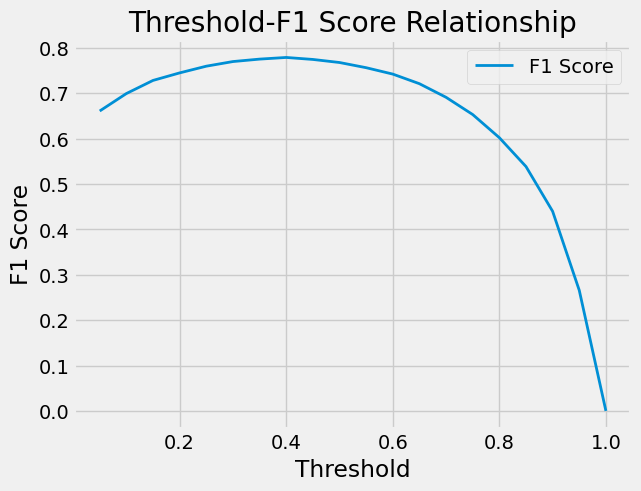

AUCPR is 0.8558100234532752.


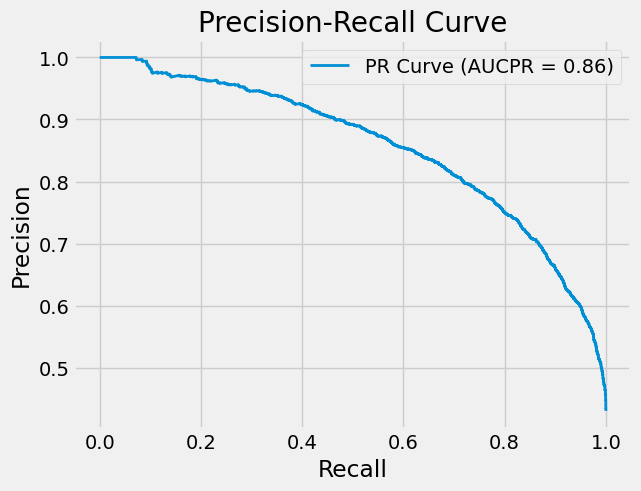

ROC Auc is 0.8831935044056257.


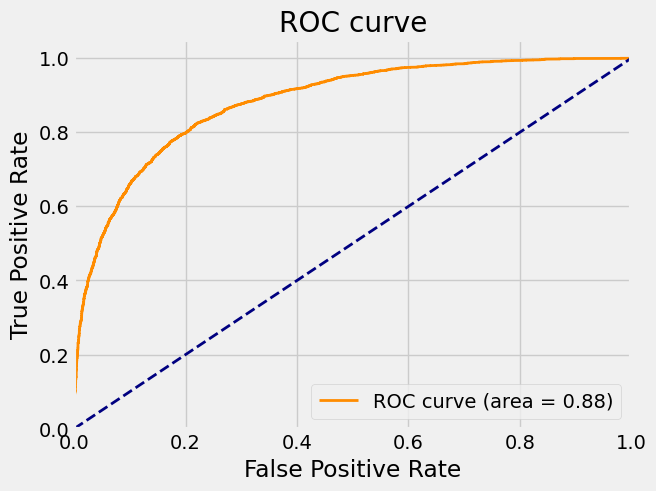

In [16]:
# plot all data point on a plot
ths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]
'''thresholds are used to determine the decision boundary for converting the predicted probabilities (from a classification model) into binary class labels (0 or 1)'''

highest_score = []
highest_f1 = 0

task = 'classification'

if task == 'forecast':
    rmse = round(np.sqrt(np.mean((preds-y_test1)**2)), 2)
    mae = np.mean(np.abs(preds-np.array(y_test1)))
    print(f'RMSE is {rmse}. MAE is {mae}')
    
elif task == 'classification':
    # PR and AUCPR
    precision, recall, thresholds = precision_recall_curve(y_test1, preds)
    aucpr = auc(recall, precision)
    
    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test1, preds)
    roc_auc = auc(fpr, tpr)
    
    # Manually count
    for threshold in ths:
        TP, FP, TN, FN = 0,0,0,0
        anses = np.where(preds<threshold, 0, 1)
        for ans, y in zip(anses, y_test1):
            if ans == y:
                if ans == 1: TP += 1
                elif ans == 0: TN +=1
            elif ans != y:
                if ans == 1: FP += 1
                elif ans == 0: FN +=1
        acc=(TP+TN)/(TP+TN+FP+FN)*100
        try:
            p, r = round(TP/(TP+FP), 4), round(TP/(TP+FN), 4)
            f1 = round(2*(p*r)/(p+r), 4)
        except:
            p, r, f1 = 'DNF', 'DNF', 'DNF'
        
        if f1 > highest_f1:
            highest_f1 = f1
            highest_score = [threshold, acc, p, r, f1]

        s = f'th: {threshold}; Acc: {acc}; precision: {p}; recall:{r}; f1:{f1}'
        print(s)
    
    # 初始化閥值列表和 F1 Score 列表
    thresholds = []
    f1_scores = []

    # 循環遍歷閥值，計算 F1 Score
    for threshold in range(5, 101, 5):
        threshold /= 100
        y_pred_threshold = [1 if pred >= threshold else 0 for pred in preds]
        f1_scores.append(f1_score(y_test1, y_pred_threshold))
        thresholds.append(threshold)

    # 繪製閥值與 F1 Score 的關係圖
    print(highest_score)
    plt.figure()
    plt.plot(thresholds, f1_scores, lw=2, label='F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('Threshold-F1 Score Relationship')
    plt.legend()
    plt.show()
    
    print(f'AUCPR is {aucpr}.')
    plt.figure()
    plt.plot(recall, precision, lw=2, label='PR Curve (AUCPR = %0.2f)' % aucpr)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
    
    print(f'ROC Auc is {roc_auc}.')
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f'ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

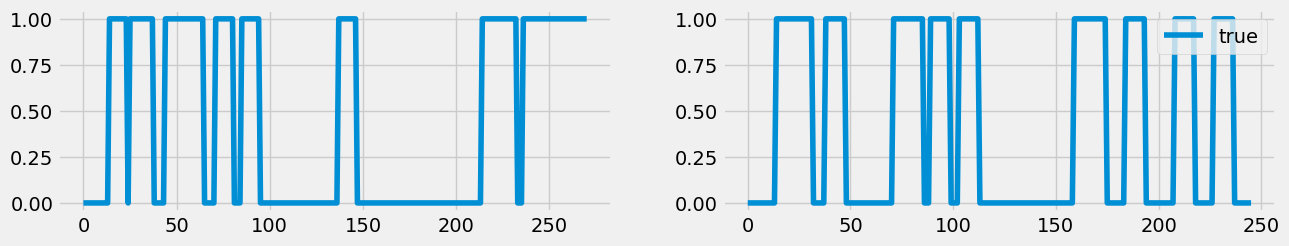

In [13]:
# visulized on many sample on validation data
sample_value = 2
# samples = random.sample(split_time_test, sample_value)
samples = [split_time_test[8], split_time_test[9]]

fig, axs = plt.subplots(1, sample_value, figsize=(14, 2.5))

# y_test
# preds

for i in range(sample_value):
    true = [y_test1[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(true, label='true')
    prediction = [preds[i] for i in range(samples[i][0], samples[i][1])]
    # prediction = [1 if preds[i] > 0.5 else 0  for i in range(samples[i][0], samples[i][1])]
    # axs[i].plot(prediction, label='pred')

plt.legend()
plt.show()

In [14]:
A = [test_dir_list[split_time_test.index(s)] for s in samples]
A

['2023-04-17_qc00_exp4_#03_All.csv', '2023-04-01_qc00_exp2_#04_B1B3.csv']

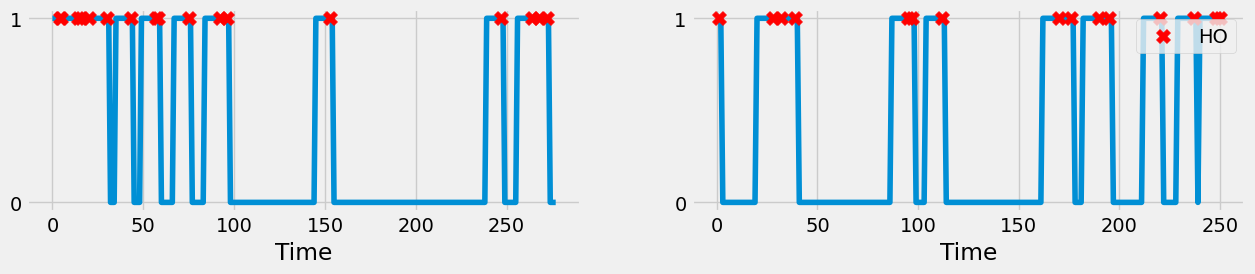

In [15]:
# Check whethet it do good on training data
sample_value = 2
samples = random.sample(split_time_train, sample_value)
preds_train = model.predict(train_data1)

fig, axs = plt.subplots(1, sample_value, figsize=(14, 2.5))

for i in range(sample_value):
    true = [y_train1[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(true)
    # Plot Handover happen place
    arr = [y_train2[i] for i in range(samples[i][0], samples[i][1])]
    indices = (np.roll(arr, -1) == 1)
    indices[0] = False    
    xy = [(i, 1) for i, x in enumerate(indices) if x == True]
    x = [a[0] for a in xy]
    y = [a[1] for a in xy]
    axs[i].scatter(x, y, marker="X", color='red', s=100, zorder=2, label='HO')

    axs[i].set_yticks([0, 1])
    axs[i].set_xlabel('Time')
    prediction = [preds_train[i] for i in range(samples[i][0], samples[i][1])]
    # prediction = [1 if preds_train[i] > 0.5 else 0  for i in range(samples[i][0], samples[i][1])]
    # axs[i].plot(prediction, label='pred')

plt.legend()
plt.show()

### Forecast

In [16]:
# Parameters
lr = 0.3
max_d = 7
n_esti = 200
subsample = 1
colsample_bytree = 0.9
reg_alpha = 0.5
gamma = 0.1
task = 'forecast'

params = {
        "objective": "reg:squarederror", "tree_method": "gpu_hist", 'eta': lr, 'max_depth': max_d,
        'subsample': subsample, 'colsample_bytree': colsample_bytree, 'alpha': reg_alpha,'gamma': gamma,  
        'seed': seed,'eval_metric': ['rmse', 'mae']
        }

In [17]:
model2 = xgb.train(
    params=params,
    dtrain=train_data2,
    num_boost_round=600,
    evals=[(train_data2, 'train'), (test_data2, 'valid')],
    early_stopping_rounds=10,
    # verbose_eval=False
)

[0]	train-rmse:2.61591	train-mae:2.24599	valid-rmse:2.66278	valid-mae:2.28004
[1]	train-rmse:2.44043	train-mae:2.07420	valid-rmse:2.53301	valid-mae:2.14621
[2]	train-rmse:2.30149	train-mae:1.93190	valid-rmse:2.43473	valid-mae:2.03606
[3]	train-rmse:2.20350	train-mae:1.83238	valid-rmse:2.37202	valid-mae:1.96223
[4]	train-rmse:2.11872	train-mae:1.74334	valid-rmse:2.32224	valid-mae:1.90019
[5]	train-rmse:2.04800	train-mae:1.67174	valid-rmse:2.28665	valid-mae:1.85448
[6]	train-rmse:1.97162	train-mae:1.59791	valid-rmse:2.25490	valid-mae:1.81392
[7]	train-rmse:1.91883	train-mae:1.54433	valid-rmse:2.23589	valid-mae:1.78608
[8]	train-rmse:1.87197	train-mae:1.50050	valid-rmse:2.22467	valid-mae:1.76977
[9]	train-rmse:1.83900	train-mae:1.46590	valid-rmse:2.21412	valid-mae:1.75590
[10]	train-rmse:1.80681	train-mae:1.43467	valid-rmse:2.20854	valid-mae:1.74642
[11]	train-rmse:1.77085	train-mae:1.40197	valid-rmse:2.20673	valid-mae:1.74279
[12]	train-rmse:1.75091	train-mae:1.38318	valid-rmse:2.20559	v

/home/vincentpai/anaconda3/envs/wmnlab/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:28:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[15]	train-rmse:1.68289	train-mae:1.31962	valid-rmse:2.19215	valid-mae:1.71978
[16]	train-rmse:1.64164	train-mae:1.28254	valid-rmse:2.19111	valid-mae:1.71323
[17]	train-rmse:1.61741	train-mae:1.26022	valid-rmse:2.17962	valid-mae:1.70130
[18]	train-rmse:1.59621	train-mae:1.24218	valid-rmse:2.18021	valid-mae:1.69967
[19]	train-rmse:1.56913	train-mae:1.21810	valid-rmse:2.17676	valid-mae:1.69311
[20]	train-rmse:1.54186	train-mae:1.19479	valid-rmse:2.17370	valid-mae:1.68681
[21]	train-rmse:1.52116	train-mae:1.17649	valid-rmse:2.17504	valid-mae:1.68444
[22]	train-rmse:1.51034	train-mae:1.16626	valid-rmse:2.17368	valid-mae:1.68235
[23]	train-rmse:1.48835	train-mae:1.14663	valid-rmse:2.17632	valid-mae:1.68540
[24]	train-rmse:1.47572	train-mae:1.13578	valid-rmse:2.17251	valid-mae:1.68219
[25]	train-rmse:1.44194	train-mae:1.10869	valid-rmse:2.16813	valid-mae:1.67864
[26]	train-rmse:1.41936	train-mae:1.08957	valid-rmse:2.16490	valid-mae:1.67433
[27]	train-rmse:1.40225	train-mae:1.07374	valid-rmse

In [18]:
preds2 = model2.predict(test_data2)

/home/vincentpai/anaconda3/envs/wmnlab/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:28:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [19]:
rmse = mean_squared_error(y_test2_fore, preds2, squared=False)
mae = mean_absolute_error(y_test2_fore, preds2)
rmse, mae

/home/vincentpai/anaconda3/envs/wmnlab/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(2.1380367363762702, 1.6375310838206232)

# grid search

## Search on task

In [22]:
import itertools

In [20]:
# Load Data
valid_ratio = 0.2
task = 'forecast'

dir_list = os.listdir(dirname)
dir_list = [f for f in dir_list if ( f.endswith('.csv') and (not 'sm' in f) ) ]

train_dir_list, test_dir_list = train_valid_split(dir_list, valid_ratio)
# train_dir_list += [f for f in os.listdir(dirname) if 'sm' in f]

# Select which feature to use.
features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']

num_of_features = len(features)

# Prediction Task
target = ['LTE_HO', 'MN_HO'] # For eNB HO.
# target = ['eNB_to_ENDC'] # Setup gNB
# target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
# target = ['RLF'] # For RLF
# target = ['SCG_RLF'] # For scg failure
# target = ['dl-loss'] # For DL loss
# target = ['ul-loss'] # For UL loss

 # record file
out = '../info/forecast_lte_HO.csv'
f_out = open(out, mode='w')
cols_out = ['t_seq','t_pred','lr','max_dep','n_esti','subsample','colsample_bytree','reg_alpha','gamma','rmse','mae']
f_out.write(','.join(cols_out)+'\n')

time_seqs = [20]
predict_ts = list(range(1,31))

# Parameters
lrs = [0.3]
max_ds = [7]
n_estis = [200]
subsamples = [1]
colsample_bytrees = [0.9]
reg_alphas = [0.5]
gammas = [0.1]
        
for time_seq, predict_t in itertools.product(time_seqs, predict_ts):

        # Data
        print('Loading training data...')
        X_train, y_train1, y_train2, split_time_train = ts_array_create(dirname, train_dir_list, time_seq)
        X_train_2d = X_train.reshape(-1, time_seq*num_of_features)
        cond = y_train2 > 0
        X_train_fore = X_train_2d[cond]
        y_train2_fore = y_train2[cond]


        print('Loading testing data...')
        X_test, y_test1, y_test2, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
        X_test_2d = X_test.reshape(-1, time_seq*num_of_features)
        cond = y_test2 > 0
        X_test_fore = X_test_2d[cond]
        y_test2_fore = y_test2[cond]

        # xgb DMatrix
        train_data1 = xgb.DMatrix(X_train_2d, label=y_train1)
        train_data2 = xgb.DMatrix(X_train_fore, label=y_train2_fore)

        test_data1 = xgb.DMatrix(X_test_2d, label=y_test1)
        test_data2 = xgb.DMatrix(X_test_fore, label=y_test2_fore)

        for lr, max_d, n_esti, subsample, colsample_bytree, reg_alpha, gamma in itertools.product(lrs, max_ds, n_estis, subsamples, colsample_bytrees, reg_alphas, gammas):

                params = {
                        "objective": "reg:squarederror", "tree_method": "gpu_hist", 'eta': lr, 'max_depth': max_d,
                        'subsample': subsample, 'colsample_bytree': colsample_bytree, 'alpha': reg_alpha,'gamma': gamma,  
                        'seed': seed,'eval_metric': ['rmse', 'mae']
                        }

                model = xgb.train(
                params=params, dtrain=train_data2, num_boost_round=600,
                evals=[(train_data2, 'train'), (test_data2, 'valid')], early_stopping_rounds=10, verbose_eval=False
                )

                preds = model.predict(test_data2)

                rmse = mean_squared_error(y_test2_fore, preds, squared=False)
                mae = mean_absolute_error(y_test2_fore, preds)

                cols_out = [time_seq, predict_t, lr, max_d, n_esti, subsample, colsample_bytree, reg_alpha, gamma, rmse,mae]
                cols_out = [str(n) for n in cols_out]
                f_out.write(','.join(cols_out)+'\n')
        
        print(f'rmse: {rmse}, mae: {mae}')
        
f_out.close()

NameError: name 'itertools' is not defined

# Classification and Forecast

## Visualization

In [24]:
test_data = xgb.DMatrix(X_test_2d)
preds_ho = model1.predict(test_data)
preds_ho_time = model2.predict(test_data)

NameError: name 'model1' is not defined

: 

In [ ]:
ans = np.where(preds_ho>0.5, preds_ho_time, 0)

In [ ]:
# visulized on many sample on validation data
sample_value = 2
# samples = random.sample(split_time_test, sample_value)
samples = [split_time_test[0], split_time_test[1]]

fig, axs = plt.subplots(1, sample_value, figsize=(14, 2.5))

for i in range(sample_value):
    
    true_ho_time = [y_test2[i] for i in range(samples[i][0], samples[i][1])]
        
    axs[i].plot(true_ho_time, label='true')
    prediciton_ho = [ans[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(prediciton_ho, label='pred')

plt.legend()
plt.show()

In [ ]:
# save model
save_path = '/home/wmnlab/Documents/sheng-ru/model/'
save_name = 'nr_HO_fcst_xgb.json'
f = os.path.join(save_path, save_name)
model2.save_model(f)